In [18]:
!pip install torch torchvision transformers opencv-python scikit-learn thop

In [19]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [20]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [21]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, AutoTokenizer
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from thop import profile

In [22]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [23]:
df.head()

,id,caption,label
1057,1058,পাইলটের শেষ মুহূর্তের প্রচেষ্টা সত্ত্বেও দুর্ঘ...,Anthropogenic
5868,5869,প্যাডেল এক্সারসাইজার মিনি এক্সারসাইজ বাইক আর্ম...,Non Informative
4195,4196,দেশাল ব্লাউজ কালেকশনে প্রতিটি ব্লাউজে রয়েছে হা...,Non Informative
4837,4838,খিচুড়ি - হাস ভুনা - আমের আচার 🌻🌻,Non Informative
4354,4355,কালকে ওরে সোফার রুমে ঘুমে রেখে এসে আমি বেডরুমে...,Non Informative


In [24]:
# --- Column cleanup ----------------------------------------------------------
df.columns = df.columns.str.strip()          # remove leading/trailing spaces
df.rename(columns={' id': 'image_id'}, inplace=True)

# --- Label text normalisation ------------------------------------------------
df['label']   = df['label'].astype(str).str.strip().str.lower()

# --- Mapping -----------------------------------------------------------------
label_mapping = {
    'flood': 0,
    'cyclone': 1,
    'earthquake': 2,
    'river erosion': 3,
    'fire': 4,
    'anthropogenic': 5
}
df['label_id'] = df['label'].map(label_mapping)

# --- Drop any rows we still can’t use ----------------------------------------
df = df.dropna(subset=['label_id', 'caption', 'id']).reset_index(drop=True)
df['label_id'] = df['label_id'].astype(int)

In [25]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [26]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()


In [27]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

In [28]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, images_folder, tokenizer, image_transforms):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'Fire': 4,
            'anthropogenic': 5
            
        }
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = str(row['caption'])
        label = int(row['label_id'])
        image_id = str(row['id']).strip()

        image_path = os.path.join(self.images_folder, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.png")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.jpeg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image {image_id} not found")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)
        text_inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        assert 0 <= label <= 5, f"Label {label} out of range"

        return {
            'input_ids': text_inputs['input_ids'].squeeze(),
            'attention_mask': text_inputs['attention_mask'].squeeze(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'original_label': self.index_to_class[label]
        }

In [29]:
images_folder = '/kaggle/input/mddb-images/Photos_Final'  # Updated to match dataset source
train_dataset = MultimodalDataset(train_data, images_folder, tokenizer, train_transforms)
valid_dataset = MultimodalDataset(valid_data, images_folder, tokenizer, valid_test_transforms)
test_dataset = MultimodalDataset(test_data, images_folder, tokenizer, valid_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [30]:

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

1899
633
634


In [35]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import AutoModel

class CoAttentionFusionWithTextSelfAttn(nn.Module):
    def __init__(self, num_classes=5, roberta_model_name='xlm-roberta-base'):
        super().__init__()

        # 1. Lightweight text encoder
        self.roberta = AutoModel.from_pretrained(roberta_model_name)

        # 2. Text self-attention
        self.text_self_attn = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=768, nhead=4, dim_feedforward=512),
            num_layers=1
        )

        # 3. EfficientNet-B0 image encoder
        effnet = models.efficientnet_b0(pretrained=True)
        self.image_backbone = nn.Sequential(*list(effnet.features.children()))
        self.img_proj = nn.Linear(1280, 768)

        # 4. Learnable [IMG_CLS] token
        self.img_cls_token = nn.Parameter(torch.randn(1, 1, 768))

        # 5. Co-attention (reduced heads)
        self.text_to_img_attn = nn.MultiheadAttention(embed_dim=768, num_heads=4, batch_first=True)
        self.img_to_text_attn = nn.MultiheadAttention(embed_dim=768, num_heads=4, batch_first=True)

        # 6. Dropout and LayerNorm
        self.dropout = nn.Dropout(0.1)
        self.text_norm = nn.LayerNorm(768)
        self.img_norm = nn.LayerNorm(768)

        # 7. Classifier
        self.classifier = nn.Sequential(
            nn.Linear(768 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        B = input_ids.size(0)

        # --- Text encoding ---
        text_out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        text_feats = text_out.last_hidden_state  # (B, T, 768)
        text_feats = self.text_self_attn(text_feats)  # (B, T, 768)
        text_feats = self.dropout(text_feats)

        # --- Image encoding ---
        img_feat_map = self.image_backbone(image)  # (B, 1280, H, W)
        _, C, H, W = img_feat_map.shape
        img_tokens = img_feat_map.view(B, C, H * W).permute(0, 2, 1)  # (B, H*W, 1280)
        img_tokens = self.img_proj(img_tokens)  # (B, H*W, 768)
        img_tokens = self.dropout(img_tokens)

        # Add learnable [IMG_CLS] token
        img_cls = self.img_cls_token.expand(B, -1, -1)  # (B, 1, 768)
        img_tokens = torch.cat([img_cls, img_tokens], dim=1)  # (B, 1+H*W, 768)

        # --- Cross-modal Co-attention ---
        text_attn, _ = self.text_to_img_attn(text_feats, img_tokens, img_tokens)
        img_attn, _ = self.img_to_text_attn(img_tokens, text_feats, text_feats)

        # Apply LayerNorm after attention
        text_attn = self.text_norm(text_attn)
        img_attn = self.img_norm(img_attn)

        # Extract [CLS] equivalents
        text_repr = text_attn[:, 0, :]  # First token of text
        img_repr = img_attn[:, 0, :]    # First image token (IMG_CLS)

        # --- Fusion and Classification ---
        fused = torch.cat([text_repr, img_repr], dim=-1)  # (B, 1536)
        return self.classifier(fused)


In [36]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CoAttentionFusionWithTextSelfAttn(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)


# Training loop with early stopping
num_epochs = 10
train_losses = []
valid_losses = []
best_valid_loss = float('inf')
best_model_path = 'best_model.pth'
patience = 3
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * input_ids.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * input_ids.size(0)

    valid_loss /= len(valid_dataset)
    valid_losses.append(valid_loss)
    

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")
    scheduler.step(valid_loss)

    # Save best model and check for early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Load best model for evaluation
model.load_state_dict(torch.load(best_model_path))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 119/119 [01:42<00:00,  1.16it/s]


Epoch 1/10, Train Loss: 1.3698, Val Loss: 0.7977


Epoch 2/10: 100%|██████████| 119/119 [01:39<00:00,  1.19it/s]


Epoch 2/10, Train Loss: 0.6842, Val Loss: 0.7681


Epoch 3/10: 100%|██████████| 119/119 [01:39<00:00,  1.19it/s]


Epoch 3/10, Train Loss: 0.5814, Val Loss: 0.6187


Epoch 4/10: 100%|██████████| 119/119 [01:39<00:00,  1.19it/s]


Epoch 4/10, Train Loss: 0.5342, Val Loss: 0.5932


Epoch 5/10: 100%|██████████| 119/119 [01:39<00:00,  1.19it/s]


Epoch 5/10, Train Loss: 0.5001, Val Loss: 0.5625


Epoch 6/10: 100%|██████████| 119/119 [01:39<00:00,  1.19it/s]


Epoch 6/10, Train Loss: 0.4776, Val Loss: 0.5592


Epoch 7/10: 100%|██████████| 119/119 [01:39<00:00,  1.20it/s]


Epoch 7/10, Train Loss: 0.4705, Val Loss: 0.5839


Epoch 8/10: 100%|██████████| 119/119 [01:39<00:00,  1.19it/s]


Epoch 8/10, Train Loss: 0.4579, Val Loss: 0.5722
Early stopping triggered after 8 epochs.


<ipython-input-36-4d2b8997fc33>:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>


Test Set Evaluation:
Accuracy: 0.9606
Precision: 0.9611
Recall: 0.9606
F1 Score: 0.9604

Classification Report:
               precision    recall  f1-score   support

        flood       0.95      0.96      0.95       114
      cyclone       0.95      0.94      0.94        93
   earthquake       0.99      0.96      0.98        84
river erosion       0.97      0.90      0.93       101
         fire       0.99      0.99      0.99       112
anthropogenic       0.94      1.00      0.97       130

     accuracy                           0.96       634
    macro avg       0.96      0.96      0.96       634
 weighted avg       0.96      0.96      0.96       634



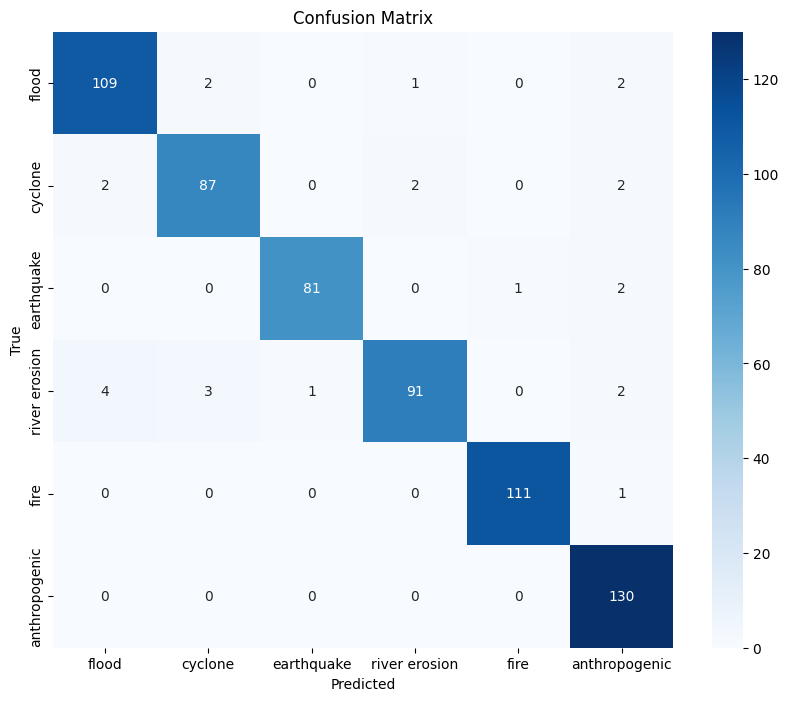

In [37]:
# Evaluation on test set
true_labels = []
pred_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, images)
        _, preds = torch.max(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic']))

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic'], yticklabels=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


📉 Epoch-wise Losses:
Epoch  1: Train Loss = 1.3698, Val Loss = 0.7977
Epoch  2: Train Loss = 0.6842, Val Loss = 0.7681
Epoch  3: Train Loss = 0.5814, Val Loss = 0.6187
Epoch  4: Train Loss = 0.5342, Val Loss = 0.5932
Epoch  5: Train Loss = 0.5001, Val Loss = 0.5625
Epoch  6: Train Loss = 0.4776, Val Loss = 0.5592
Epoch  7: Train Loss = 0.4705, Val Loss = 0.5839
Epoch  8: Train Loss = 0.4579, Val Loss = 0.5722


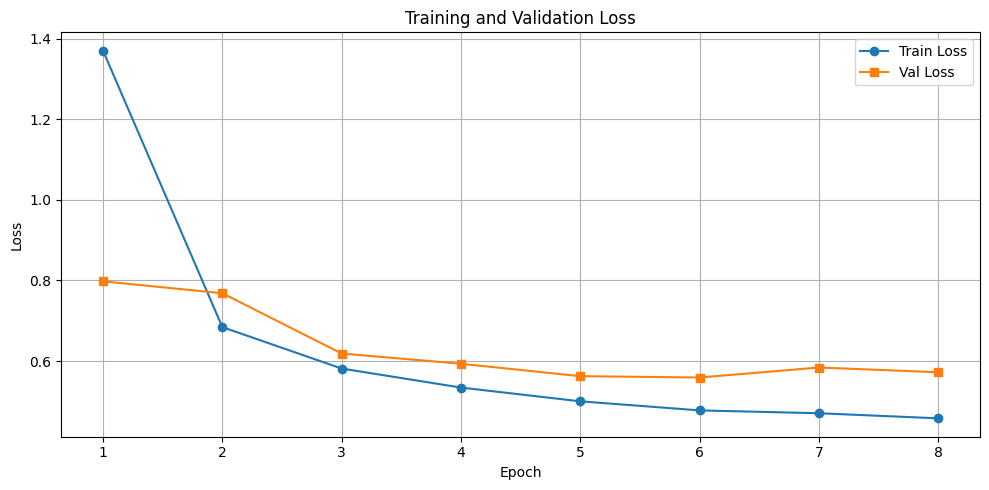

In [38]:
import matplotlib.pyplot as plt

# Print epoch-wise losses
print("\n📉 Epoch-wise Losses:")
for i, (train, val) in enumerate(zip(train_losses, valid_losses), start=1):
    print(f"Epoch {i:2d}: Train Loss = {train:.4f}, Val Loss = {val:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Val Loss', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


